In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit


# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 6.7})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial')

In [ ]:
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)
    

from matplotlib.backends.backend_pdf import PdfPages


def create_movie(indices,field_time_out,x,y,f,t, monitor_lambdas,name='',type='t',log=False,path="",frames_per_second=1,rem_frames=False, normalize=True, a=5/3, movie=False,directory_patches={"path":"","chi":[],"L":[],"sample":[]}):
    frames = []
    field_time_out = field_time_out[indices[0],indices[1],indices[2],:,:,:]
    max_values = field_time_out.max(axis=(0,1)) if normalize else 1

    sim_data = AM.loadFromFile(key = tidy3dAPI, 
                               file_path=rf"{directory_patches["path"]}/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics_L={directory_patches["L"][indices[1]]} nu=0.2 - 0.48/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics Beam Spreading 0.2 - 0.48 - Sample_{directory_patches["sample"][indices[2]]} 50.0ps L={directory_patches["L"][indices[1]]}a.txt"
                               ,save_path=rf"F:\2D SHU Chi Statistics",
                               get_ref=False,verbose=False
                               ).sim_data
    fig1, ax_1 = plt.subplots()
    ax1=sim_data.simulation.plot_structures_eps(freq=monitor_lambdas[0], cbar=False, z=0, ax=ax_1,
                reverse=False)

    # Create a new figure for plotting the shapes
    patches_list = ax1.patches
    plt.close(fig1)


    field_time_out = field_time_out/max_values
    x= x/a
    y =y/a

    # Define the colors: Blue -> White -> Yellow -> Green -> Red
    colors = [
              (1, 1, 1),  # White
              (0, 0, 1),  # Blue
              (1, 1, 0),  # Yellow
              (0, 1, 0),  # Green
              (1, 0, 0), #Red
              (0, 0, 0), # Black
              ]  
    
    # Create a custom colormap
    n_bins = 500  # Number of bins for smooth transition
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)
    if log:
        field_log = np.log10((field_time_out))
        folder_pics = "logPics"
        
    else:
        field_log = ((field_time_out))
        folder_pics = "linPics"

    if not os.path.exists(f'{path}/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics_L={directory_patches["L"][indices[1]]} nu=0.2 - 0.48/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics Beam Spreading 0.2 - 0.48 - Sample_{directory_patches["sample"][indices[2]]} 50.0ps L={directory_patches["L"][indices[1]]}a/{folder_pics}'):
            os.makedirs(f'{path}/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics_L={directory_patches["L"][indices[1]]} nu=0.2 - 0.48/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics Beam Spreading 0.2 - 0.48 - Sample_{directory_patches["sample"][indices[2]]} 50.0ps L={directory_patches["L"][indices[1]]}a/{folder_pics}')
            print(f"Folder {path}/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics_L={directory_patches["L"][indices[1]]} nu=0.2 - 0.48/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics Beam Spreading 0.2 - 0.48 - Sample_{directory_patches["sample"][indices[2]]} 50.0ps L={directory_patches["L"][indices[1]]}a/{folder_pics} created successfully.")



    for i in range(np.shape(field_time_out)[-1]):
        if os.path.isfile(f'{path}/{folder_pics}/frame_{i}.pdf'):
            frames.append(f'{path}/{folder_pics}/frame_{i}.pdf')
            continue
        fig, ax = plt.subplots(figsize=(3.5, 4))
       
        im =plt.imshow(field_log[:,:,i], vmin = np.min(field_log[:,:,i]), vmax = np.max(field_log[:,:,i]), 
                 extent =[np.min(y),np.max(y), np.min(x),np.max(x)], 
                    interpolation ='gaussian', origin ='lower', cmap=cmap,aspect='equal') 
        if type=="t":
            ax.set_title(f'Time: {t[i]} ps')
        else:
            ax.set_title(f'$\\nu$: {f[i]:.4g}')
        
        cbar = fig.colorbar(im, ax=ax, 
                            orientation='vertical', fraction=0.1, pad=0.1, shrink=0.3)
        # cbar.ax.tick_params(labelsize=16)
        cbar.set_label(rf"$|E|^2$ Normalized")
        cbar.ax.yaxis.set_label_position('left')
        ax.set_ylabel(rf"x(a)")
        ax.set_xlabel(rf"y(a)")
        ax.set_xlim(-25,25)
        ax.tick_params(which='major')
        for patch in patches_list:
            path_patch = patch.get_path()  
            new_patch = patches.PathPatch(path_patch, edgecolor= (0,0,0, 0.55),facecolor="none")
            # new_patch = patches.PathPatch(path_patch, edgecolor= (0,0,0, 0.08),facecolor="none")
            t2 = matplotlib.transforms.Affine2D().rotate_deg(90) + ax.transData
            new_patch.set_transform(t2)

            ax.add_patch(new_patch)


        ax.set_aspect('auto', adjustable='box')
        # Save the frame
        frame_path = f'{path}/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics_L={directory_patches["L"][indices[1]]} nu=0.2 - 0.48/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics Beam Spreading 0.2 - 0.48 - Sample_{directory_patches["sample"][indices[2]]} 50.0ps L={directory_patches["L"][indices[1]]}a/{folder_pics}/frame_{i}.pdf'
        fig.savefig(frame_path)
        plt.close(fig)
        raise(Exception)
        frames.append(f'{path}/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics_L={directory_patches["L"][indices[1]]} nu=0.2 - 0.48/chi_{directory_patches["chi"][indices[0]]:.2f}_N_10000_posics Beam Spreading 0.2 - 0.48 - Sample_{directory_patches["sample"][indices[2]]} 50.0ps L={directory_patches["L"][indices[1]]}a/{folder_pics}/frame_{i}.pdf')
      
        
    if movie:
        name_movie = f'{path}/{name}.mp4' if name else f'output/anderson/d(t) analysis/Diameter d(t) at output of the structure Range - {monitor_lambdas[0]:.3g} - {monitor_lambdas[-1]:.3g}.mp4'
        with imageio.get_writer(name_movie, fps=frames_per_second) as writer:
            for frame in frames:
                image = imageio.imread(frame)
                writer.append_data(image)
    
    # Optionally, remove the individual frames if no longer needed
    if rem_frames:
        for frame in frames:
            os.remove(frame)
    
    return ""

In [3]:
output_file = rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\intensities.h5"

In [4]:
data = []
with h5py.File(output_file, 'r') as h5f:
    data = {
            "data_field_intensities": h5f["data_field_intensities"][:],
            "chi":np.array(h5f["chi"]),
            "size":np.array(h5f["size"]),
            "sample":np.array(h5f["sample"]),
            "x":np.array(h5f["x"]),
            "y":np.array(h5f["y"]),
            "f":np.array(h5f["f"]),
        
        }
        
            

In [5]:
import scipy.integrate
def IPR(intensity_array,x,y):
    integral_1 = scipy.integrate.trapezoid(scipy.integrate.trapezoid(intensity_array**2, x=y, axis=1), x=x, axis=0)
    integral_2 = scipy.integrate.trapezoid(scipy.integrate.trapezoid(intensity_array, x=y, axis=1), x=x, axis=0)**2
    return ((integral_1/integral_2))

In [6]:
np.shape(data["data_field_intensities"][:,:,:,:,:,:])

(13, 16, 5, 957, 172, 150)

In [7]:
np.array(data["chi"],dtype=float)

array([0.2 , 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39,
       0.4 , 0.  ])

In [8]:
directory = rf"H:\phd stuff\tidy3d\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain"


In [130]:
create_movie((8,9,2),data["data_field_intensities"],data["x"],data["y"],f=data["f"]/td.C_0,t=0, monitor_lambdas=np.array([data["f"][0],data["f"][-1]])/td.C_0,type='f',log=False,path=rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain/Field Maps", 
             normalize=True, a=1, movie=False,directory_patches={"path":directory,"chi":data["chi"],"L":np.array(data["size"],dtype=int),"sample":np.array(data["sample"],dtype=int)})

Configured successfully.


Exception: 

In [11]:
# Define the colors: Blue -> White -> Yellow -> Green -> Red
colors = [
          (1, 1, 1),  # White
          (0, 0, 1),  # Blue
          (1, 1, 0),  # Yellow
          (0, 1, 0),  # Green
          (1, 0, 0), #Red
          (0, 0, 0), # Black
          ]  

# Create a custom colormap
n_bins = 500  # Number of bins for smooth transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)




f = data["f"]/td.C_0
average_ipr = np.zeros(shape=(11,16,150))
# for i,chi in enumerate(data["data_field_intensities"]):
#     if i in [0,12]:
#         continue
#     for j,length in enumerate(chi): 
#         ipr_values = []
#         l = data["size"][j]/2
#         index_y = np.where(np.bool_(data["y"]>=-l) & np.bool_(data["y"]<=l))[0]
#         for k,sample in enumerate(length):
#             ipr_values.append(IPR(sample[:,index_y,:],data["x"],data["y"][index_y]))
#         average_ipr[i-1,j]=np.mean(ipr_values,axis=0)



In [12]:

# for h, length in enumerate(data["size"]):
#     if length<15:
#         continue
#     fig, ax = plt.subplots(figsize=(14,9))
#     xi = 2*length*(average_ipr[:,h,:])
#     im=plt.imshow(xi, vmin = np.min(xi), vmax = np.max(xi), 
#                      extent =[np.min(f),np.max(f), 0.3,0.4], 
#                         interpolation ='gaussian', origin ='lower', cmap=cmap,aspect='equal') 
#     # Add colorbar for reference
#     cbar = fig.colorbar(im, ax=ax, label=rf"$a/ \xi$",orientation='vertical', fraction=0.02, pad=0.04)

#     plt.xlabel(rf"$\nu$")
#     plt.ylabel(rf"$\chi$")
#     plt.title(rf"L={length}")

#     plt.show()

In [13]:
data_intensities_exit = []

with h5py.File(rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\intensities_exit.h5", 'r') as h5f:
    data_intensities_exit = {
            "data_field_intensities": h5f["data_field_intensities"][:],
            "data_field_intensities_2": h5f["data_field_intensities_2"][:],
            "chi":np.array(h5f["chi"]),
            "size":np.array(h5f["size"]),
            "sample":np.array(h5f["sample"]),
            "x":np.array(h5f["x"]),
            "f":np.array(h5f["f"]),
        
        }
        
def calculate_IPR(intensity_array,x1):
    values = intensity_array
    integral_1 = scipy.integrate.simpson(values**2, x=x1, axis=0)
    integral_2 = scipy.integrate.simpson(values, x=x1,axis=0)**2

    return integral_1/integral_2

average_xis_exit = np.zeros(shape=(11,16,150))
# data_exit = data_intensities_exit["data_field_intensities_2"]
data_exit = np.copy(data_intensities_exit["data_field_intensities"])
for i,chi in enumerate(data_exit):
    if i in [0,12]:
        continue
    for j,length in enumerate(chi): 
        xis = []
        for k,sample in enumerate(length):
            max_value = np.max(sample)
            sample_normalized = sample/max_value
            sample_normalized[sample_normalized < 1e-6]=0
            # raise(Exception)
            xis.append(calculate_IPR(sample_normalized,data_intensities_exit["x"]))

        average_xis_exit[i-1,j]=np.mean(xis,axis=0)

average_xis_exit[np.isnan(average_xis_exit)] = 0
average_xis_exit[np.isinf(average_xis_exit)] = 0

C:\Users\HernandF\AppData\Local\Temp\ipykernel_18556\3801106609.py:20: RuntimeWarning: invalid value encountered in divide
  return integral_1/integral_2


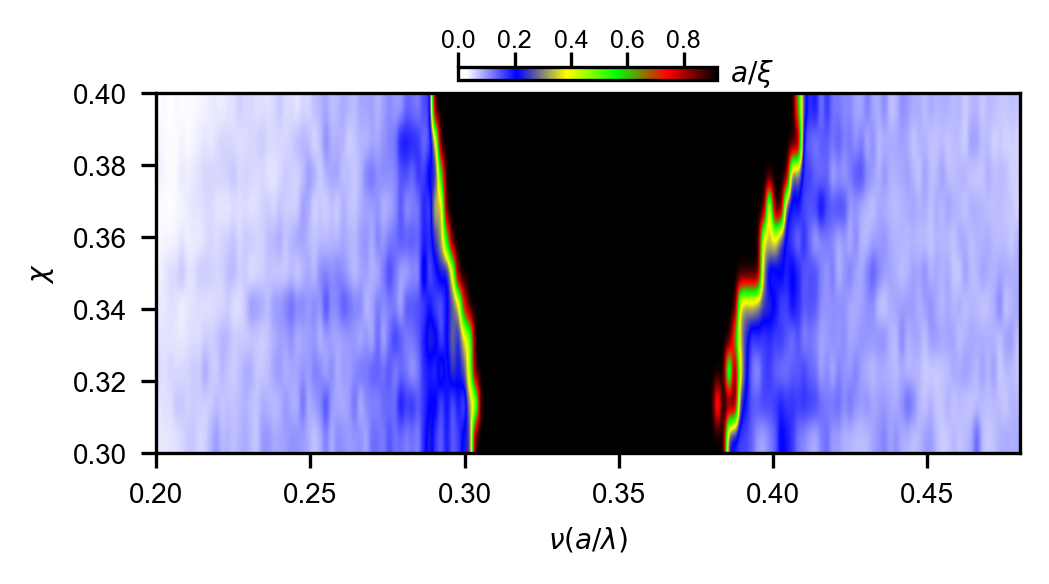

In [14]:
from matplotlib.ticker import MultipleLocator


f = data_intensities_exit["f"]/td.C_0
k,l = 0,0
for h, length in enumerate(data_intensities_exit["size"]):
    if h not in [14]:
        continue
    fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
    value = np.copy(average_xis_exit[:,h,:])
    value[value == 0]=0.92
    im=ax.imshow(value, vmin = np.min(value), vmax = np.max(value), 
                     extent =[np.min(f),np.max(f), 0.3,0.4], 
                        origin ='lower', cmap=cmap,aspect='auto',interpolation="gaussian") 
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.03, location="top", shrink=0.3)
    cbar.ax.text(1.05, 0.5, rf"$a/ \xi$", va='center', ha='left', transform=cbar.ax.transAxes)

    cbar.set_ticks([0,0.2,0.4,0.6,0.8])
    cbar.ax.tick_params(labelsize=6,pad=0)
    ax.set_xlabel(rf"$\nu(a/\lambda)$")
    ax.set_ylabel(rf"$\chi$")
    ax.tick_params(axis='both', which='major')

    plt.tight_layout()
    plt.savefig(rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\Figures/ipr_map.pdf")
    plt.show()


C:\Users\HernandF\AppData\Local\Temp\ipykernel_18556\1952460630.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(f[5:],moving_average(1/average_xis_exit[7,h,:],6), linewidth=2,label=rf"$\chi={data_intensities_exit["chi"][8]}$",color="#0f084b")


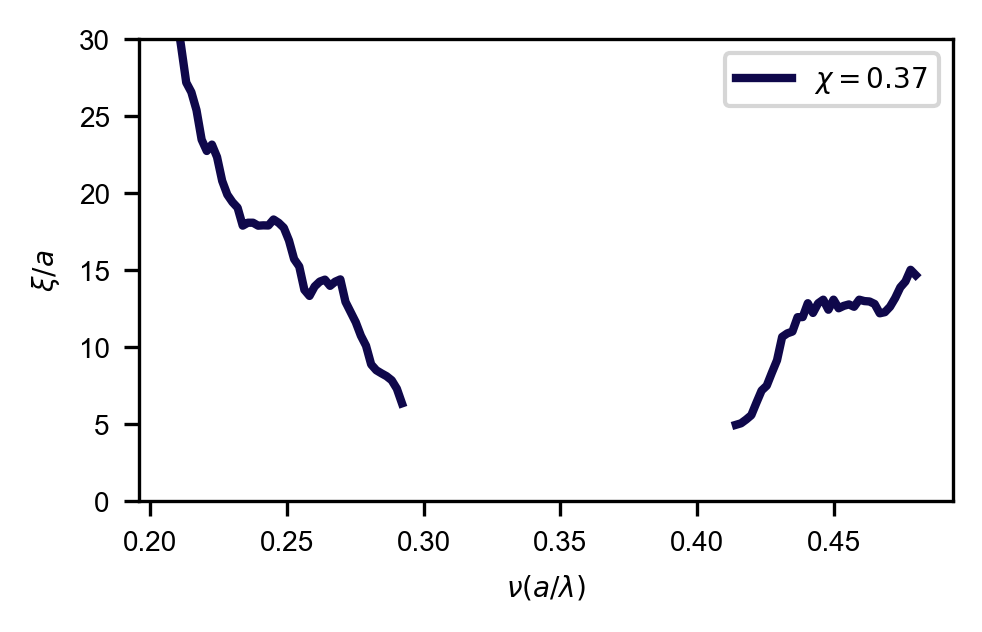

In [117]:
def moving_average(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
plt.plot(f[5:],moving_average(1/average_xis_exit[7,h,:],6), linewidth=2,label=rf"$\chi={data_intensities_exit["chi"][8]}$",color="#0f084b")
# plt.plot(f[5:],moving_average(1/average_xis_exit[5,h,:],6), linewidth=0.5,label=rf"$\chi={data_intensities_exit["chi"][6]}$")
# plt.plot(f[5:],moving_average(1/average_xis_exit[10,h,:],6), linewidth=0.5,label=rf"$\chi={data_intensities_exit["chi"][11]}$")
# plt.plot(f,(1/value[4,:]), linewidth=0.5,label=rf"$\chi={data_intensities_exit["chi"][5]}$")
# plt.plot(f,(1/value[7,:]), linewidth=0.5,label=rf"$\chi={data_intensities_exit["chi"][8]}$")
plt.legend()
plt.xlabel(rf"$\nu(a/\lambda)$")
plt.ylabel(rf"$\xi/a$")
plt.ylim(0,30)
plt.savefig(rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\Figures/ipr_freq_line.pdf",bbox_inches='tight')


In [93]:
# from matplotlib.ticker import MultipleLocator


# f = data_intensities_exit["f"]/td.C_0
# fig, ax = plt.subplots(ncols=3,nrows=3,figsize=(30,15))
# k,l = 0,0
# for h, length in enumerate(data_intensities_exit["size"]):
#     if h not in [7,8,9,10,11,12,13,14,15]:
#         continue
    
#     value = average_xis_exit[:,h,:]
#     im=ax[k,l].imshow(value, vmin = np.min(value), vmax = 1.4, 
#                      extent =[np.min(f),np.max(f), 0.3,0.4], 
#                         origin ='lower', cmap=cmap,aspect='equal',interpolation="gaussian") 
#     ax[k, l].set_title(rf"L={length}a", fontsize=30)
    
#     # Set x and y labels only on the edges
#     if k == 2:  # Bottom row
#         ax[k, l].set_xlabel(r"$\nu$", fontsize=30)
#     else:
#         ax[k, l].set_xticklabels([])  # Hide x labels for other rows

#     if l == 0:  # Leftmost column
#         ax[k, l].set_ylabel(r"$\chi$", fontsize=30)
#     else:
#         ax[k, l].set_yticklabels([])  # Hide y labels for other columns


#     # Set tick density using MultipleLocator
#     ax[k, l].xaxis.set_major_locator(MultipleLocator(0.05))  # Adjust for desired x-tick density
#     ax[k, l].yaxis.set_major_locator(MultipleLocator(0.02))  # Adjust for desired y-tick density


#     ax[k, l].tick_params(which="major", labelsize=20)

    

#     l += 1
#     if l >= 3:
#         l = 0
#         k += 1
#     # Add colorbar for reference


# plt.subplots_adjust(wspace=0.03, hspace=0.07)

# cbar = fig.colorbar(im, ax=ax,orientation='vertical', fraction=0.02, pad=0.04)
# cbar.ax.tick_params(labelsize=25)
# cbar.set_label(rf"$a/ \xi$", fontsize=30
# )
# cbar.ax.yaxis.set_label_position('left')
# fig.savefig(rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\Figures\freq_loc_map.pdf")
# plt.show()

In [94]:
data_exit = data_intensities_exit["data_field_intensities"]
value = np.mean(data_exit,axis=2)[4,15,:,:]
print(np.max(value))
print(np.min(value))
value[value/np.max(value) < 1e-3] = 0
value_normalized = value/np.max(value,axis=(0))
value_normalized[np.isnan(value_normalized)] = 0

4.872518825899753e-28
1.9294397279977475e-39


C:\Users\HernandF\AppData\Local\Temp\ipykernel_18556\1414309704.py:6: RuntimeWarning: invalid value encountered in divide
  value_normalized = value/np.max(value,axis=(0))


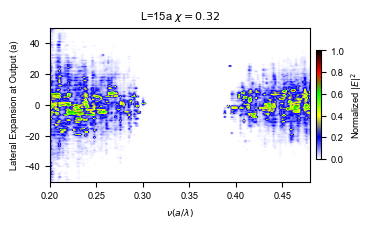

In [95]:
f = data_intensities_exit["f"]/td.C_0
fig, ax = plt.subplots(figsize=(3.5,2))
im=plt.imshow(value_normalized, vmin = np.min(value_normalized), vmax = np.max(value_normalized), 
                 extent =[np.min(f),np.max(f), -50,50], 
                    aspect='auto', interpolation="gaussian", cmap=cmap) 
# Add colorbar for reference
cbar = fig.colorbar(im, ax=ax, label=rf"$a/ \xi$",orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label(rf"Normalized $|E|^2$"
)
plt.xlabel(rf"$\nu(a/\lambda)$")
plt.ylabel(rf"Lateral Expansion at Output (a)")
plt.title(rf"L=15a $\chi=0.32$")
plt.savefig(rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\Figures\intensity_exit_freq.pdf",bbox_inches='tight')
plt.show()

In [96]:
output_file = rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\fluxes_right.h5"
data_right = []
with h5py.File(output_file, 'r') as h5f:
    data_right = {
            "flux": h5f["data_field_intensities"][:],
            "chi":np.array(h5f["chi"]),
            "size":np.array(h5f["size"]),
            "sample":np.array(h5f["sample"]),
            "f":np.array(h5f["f"]),
        
        }
        
            

In [97]:
output_file = rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\fluxes_left.h5"
data_left = []
with h5py.File(output_file, 'r') as h5f:
    data_left = {
            "flux": h5f["data_field_intensities"][:],
            "chi":np.array(h5f["chi"]),
            "size":np.array(h5f["size"]),
            "sample":np.array(h5f["sample"]),
            "f":np.array(h5f["f"]),
        
        }

In [98]:
ref_right = data_right["flux"][-1,:,0,:]
ref_left = data_left["flux"][-1,:,0,:]

In [99]:
np.shape(data_right["flux"][-1])

(16, 5, 150)

In [100]:
mean_right = np.mean(data_right["flux"], axis=2)
mean_left = np.mean(data_left["flux"], axis=2)


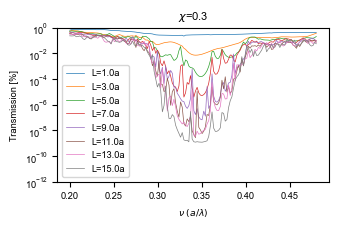

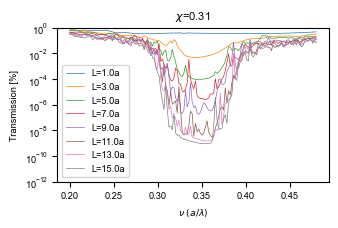

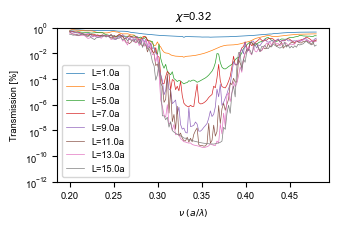

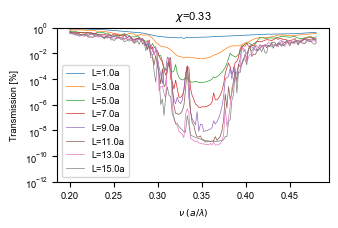

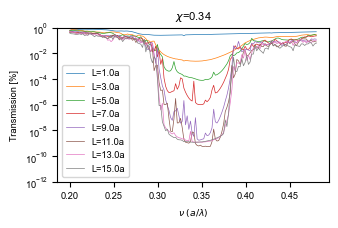

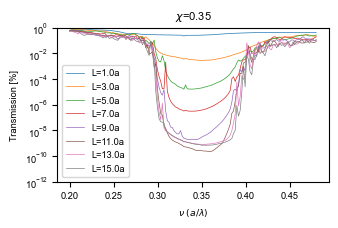

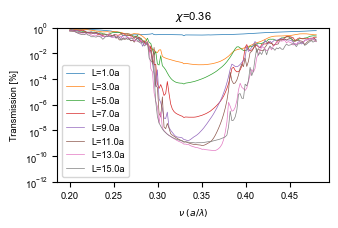

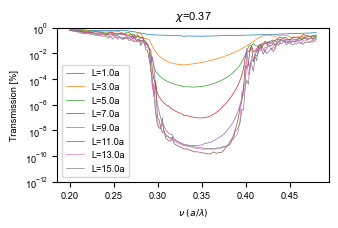

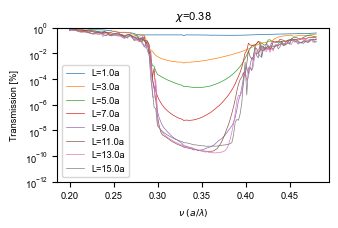

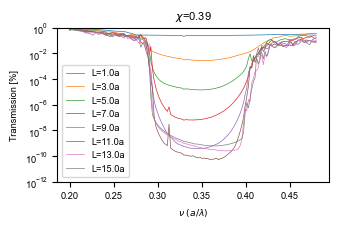

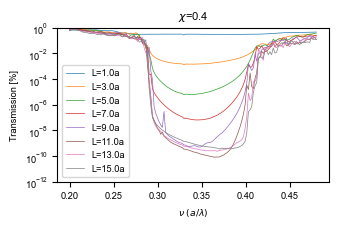

In [101]:
for i,chi in enumerate(data_right["flux"]):
    if i in [0,12]:
        continue
    fig, ax = plt.subplots(figsize=(3.5,2))
    for j,length in enumerate(chi): 
        if j in [0,2,4,6,8,10,12,14]:
            continue
        transmission_normalized_right =  mean_right[i,j,:] / ref_right[j,:]
        # transmission_normalized_left =mean_left[i,j,:] / ref_left[j,:]
        plt.plot(data_right["f"]/td.C_0,transmission_normalized_right, label=rf"L={data["size"][j]}a",linewidth=0.5)
        # plt.scatter(data_left["f"]/td.C_0,transmission_normalized_left, label="left")
    plt.xlabel(rf'$\nu$ $(a/\lambda)$')
    plt.ylabel('Transmission [%]')
    plt.yscale("log")
    plt.title(rf"$\chi$={data["chi"][i]}")
    plt.ylim(1e-12,1)
    plt.legend()
    plt.savefig(rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\Figures\Transmission/chi={data["chi"][i]}.pdf",bbox_inches='tight')
    plt.show()

In [102]:
def fit_xi(L,xi):
    return -2*L/xi

In [103]:
right_transmission_data = data_right["flux"][1:-1,:,:]
np.shape(right_transmission_data)

(11, 16, 5, 150)

In [104]:
right_transmission_data_normalized = right_transmission_data/ref_right[np.newaxis,:,np.newaxis,:]

In [105]:
log_transmission =np.log(right_transmission_data_normalized)
log_transmission[np.isnan(log_transmission)]=0

np.shape(log_transmission)

C:\Users\HernandF\AppData\Local\Temp\ipykernel_18556\1167483576.py:1: RuntimeWarning: invalid value encountered in log
  log_transmission =np.log(right_transmission_data_normalized)


(11, 16, 5, 150)

In [106]:
decay_length = np.zeros(shape=(11,5,150))
for i,chi in enumerate(log_transmission):
 for k in range(0,5):
    for j in range (0,150):
        popt, _ = curve_fit(fit_xi,data["size"],chi[:,k,j])
        # plt.scatter(data["size"],chi[:,k,j])
        # plt.plot(data["size"],fit_xi(data["size"],popt[0]))
        # plt.ylabel(rf"Log(T)")
        # plt.xlabel(rf"L [a]")
        # path_new = rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\Figures\decay\chi={data_left["chi"][i+1]}\nu={f[j]:.4g}"
        # if not os.path.exists(f'{path_new}'):
        #     os.makedirs(f'{path_new}')
        # plt.title(rf"$\nu=${f[j]:.4g} - $\chi=${data_left["chi"][i+1]}")
        # plt.savefig(rf"{path_new}/sample_{k}.png")
        # plt.close()
        decay_length[i,k,j]=popt[0]

In [107]:
average_decay_length = np.mean(decay_length,axis=1)
np.shape(average_decay_length)

(11, 150)

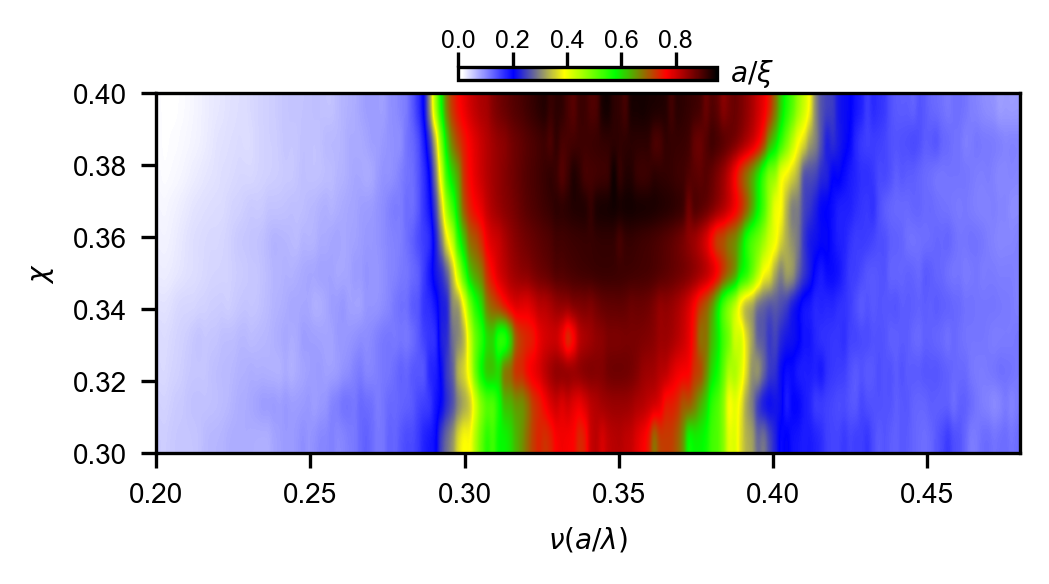

In [108]:

fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
im=plt.imshow(1/average_decay_length, vmin = np.min(1/average_decay_length), vmax = np.max(1/average_decay_length), 
                 extent =[np.min(f),np.max(f), 0.3,0.4], 
                    interpolation ='gaussian', origin ='lower', cmap=cmap,aspect='auto') 
# Add colorbar for reference

cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.03, location="top", shrink=0.3)
cbar.ax.text(1.05, 0.5, rf"$a/ \xi$", va='center', ha='left', transform=cbar.ax.transAxes)

cbar.set_ticks([0,0.2,0.4,0.6,0.8])
cbar.ax.tick_params(labelsize=6,pad=0)
ax.set_xlabel(rf"$\nu(a/\lambda)$")
ax.set_ylabel(rf"$\chi$")
ax.tick_params(axis='both', which='major')

plt.tight_layout()
plt.savefig(rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\Figures/map_decay_length.pdf")
# plt.close(fig)
plt.show()

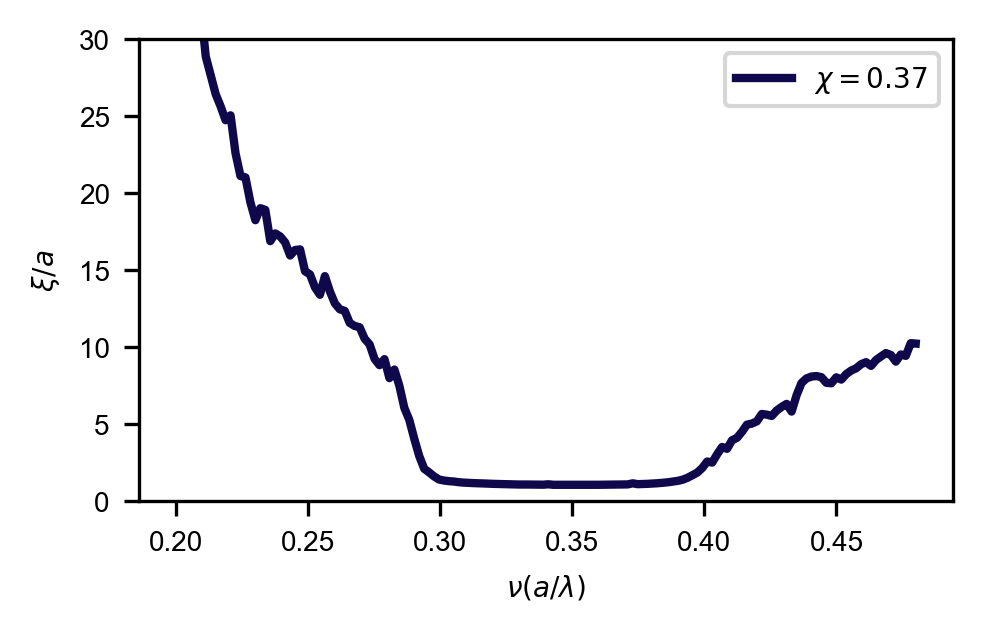

In [116]:
fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
plt.plot(f,average_decay_length[7,:], linewidth=2,label=rf"$\chi={data_right["chi"][8]}$",color="#0f084b")
# plt.plot(f,average_decay_length[5,:], linewidth=0.5,label=rf"$\chi={data_right["chi"][6]}$")
# plt.plot(f,average_decay_length[10,:], linewidth=0.5,label=rf"$\chi={data_right["chi"][11]}$")
plt.legend()
plt.xlabel(rf"$\nu(a/\lambda)$")
plt.ylabel(rf"$\xi/a$")
plt.ylim(0,30)
plt.savefig(rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\Figures/decay_length_line.pdf",bbox_inches='tight')
plt.show()
